In [ ]:
from google.colab import drive
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.transforms.functional import convert_image_dtype
# semantic segmentation pre-trained model
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.utils import draw_segmentation_masks

import ast
import math
import cv2
from google.colab.patches import cv2_imshow
import glob
import numpy as np
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps
import PIL

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
from google.colab import drive
# Google Colab with Personal Google Drive
drive.mount('/content/drive')
# Change to project folder
path = r"/content/drive/MyDrive/COMP6200 Master Project"
os.chdir(path)
os.path.abspath(os.curdir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/COMP6200 Master Project'

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(torch.__version__)
print(torch.cuda.is_available())
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print(torch.cuda.device_count())

1.12.1+cu113
False


In [ ]:
train_root = r'./data/UBIRIS_v2_recog/train'
val_root = r'./data/UBIRIS_v2_recog/val'
test_root = r'./data/UBIRIS_v2_recog/test'

UBIRIS_v2_recog_train = ImageFolder(root=train_root)
UBIRIS_v2_recog_val = ImageFolder(root=val_root)
UBIRIS_v2_recog_test = ImageFolder(root=test_root)

In [ ]:
train_mask_root = r'./data/UBIRIS_v2_truth_masks/train'
val_mask_root = r'./data/UBIRIS_v2_truth_masks/val'
test_mask_root = r'./data/UBIRIS_v2_truth_masks/test'

UBIRIS_v2_mask_train = ImageFolder(root=train_mask_root)
UBIRIS_v2_mask_val = ImageFolder(root=val_mask_root)
UBIRIS_v2_mask_test = ImageFolder(root=test_mask_root)

In [ ]:
id2label={
        '0': '000',
        '1': '001',
        '2': '002',
        '3': '003',
        '4': '004',
        '5': '005',
        '6': '006',
        '7': '007',
        '8': '008',
        '9': '009',
        '10': '010',
        '11': '011',
        '12': '012',
        '13': '013',
        '14': '014',
        '15': '015',
        '16': '016',
        '17': '017',
        '18': '018',
        '19': '019',
        '20': '020',
        '21': '021',
        '22': '022',
        '23': '023',
        '24': '024',}

In [ ]:
# UBIRIS_v2_recog_train.imgs
# UBIRIS_v2_mask_train.imgs

# Draw Iris

In [ ]:
image, label = UBIRIS_v2_recog_train[0]

In [ ]:
mask, label = UBIRIS_v2_mask_train[0]

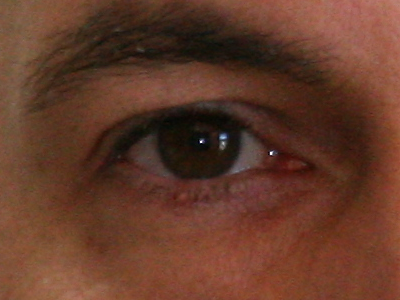

In [ ]:
display(image)

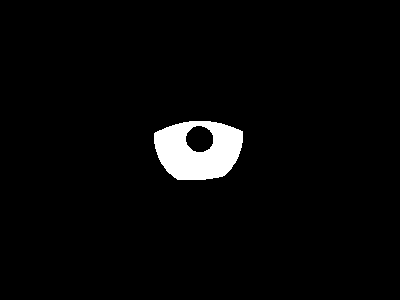

In [ ]:
display(mask)

In [ ]:
image_tensor = F.pil_to_tensor(image)
image_tensor

In [ ]:
mask_tensor = F.pil_to_tensor(mask)
mask_tensor = ~mask_tensor.type(torch.bool)
mask_tensor

In [ ]:
iris_only = draw_segmentation_masks(image_tensor, mask_tensor, alpha=1, colors=(0,0,0))

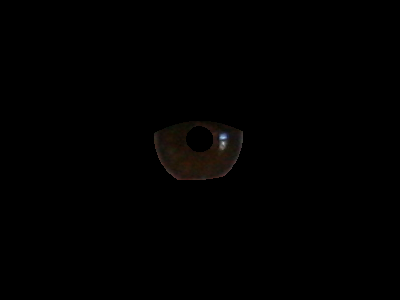

In [ ]:
iris_only_PIL = transforms.ToPILImage()(iris_only)
display(iris_only_PIL)

In [ ]:
iris_only_np = np.array(iris_only_PIL)
iris_only_np.shape

(300, 400, 3)

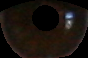

In [ ]:
# To PIL
iris_only_PIL = transforms.ToPILImage()(iris_only)
# To numpy
iris_only_np = np.array(iris_only_PIL)
# Find Iris Only
positions = np.nonzero(iris_only_np)
top = positions[0].min()
bottom = positions[0].max()
left = positions[1].min()
right = positions[1].max()
# Crop Iris
box = (left, top, right, bottom)
iris_only_PIL_crop = iris_only_PIL.crop(box)
display(iris_only_PIL_crop)

In [ ]:
path, label = UBIRIS_v2_recog_train.imgs[0]
path.split('/')[-1]

'C1_S1_I1.tiff'

In [ ]:
def get_iris_only(image_dataset, mask_dataset, mode):
  save_path_root = r'./data/UBIRIS_v2_iris_only/{mode}'.format(mode=mode)
  for (image, image_label), (mask, mask_label), (path, label) in zip(image_dataset, mask_dataset, image_dataset.imgs):
    # Image name
    image_name = path.split('/')[-1]
    # draw Iris
    image_tensor = F.pil_to_tensor(image)
    mask_tensor = F.pil_to_tensor(mask)
    mask_tensor = ~mask_tensor.type(torch.bool)
    iris_only = draw_segmentation_masks(image_tensor, mask_tensor, alpha=1, colors=(0,0,0))
    # To PIL
    iris_only_PIL = transforms.ToPILImage()(iris_only)
    # To numpy
    iris_only_np = np.array(iris_only_PIL)
    # Find Iris Only
    positions = np.nonzero(iris_only_np)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()
    # Crop Iris
    box = (left, top, right, bottom)
    iris_only_PIL_crop = iris_only_PIL.crop(box)
    iris_only_PIL_crop_resize = iris_only_PIL_crop.resize((256,256)) 
    # display(iris_only_PIL_crop_resize)

    iris_folder_name = id2label['{key}'.format(key=image_label)]

    # save picture after segmantation
    output_file_path = os.path.normpath(os.path.abspath(save_path_root)+'/'+ iris_folder_name)

    if (os.path.isdir(output_file_path) == False):
        os.makedirs(output_file_path)

    iris_only_PIL_crop_resize.save((output_file_path + "/" + image_name))


In [ ]:
get_iris_only(UBIRIS_v2_recog_train, UBIRIS_v2_mask_train, 'train')

In [ ]:
get_iris_only(UBIRIS_v2_recog_val, UBIRIS_v2_mask_val, 'val')

In [ ]:
get_iris_only(UBIRIS_v2_recog_test, UBIRIS_v2_mask_test, 'test')